# Gravitational waves detection

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.





In [1]:
import h5py
import emcee
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from astropy.table import Table
import tqdm
import corner

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.manifold import Isomap
from sklearn import preprocessing

# Data fetching

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [4]:
chi1x = f['chi1x'][::1000]
chi1y = f['chi1y'][::1000]
chi1z = f['chi1z'][::1000]
chi2x = f['chi2x'][::1000]
chi2y = f['chi2x'][::1000]
chi2z = f['chi2x'][::1000]
dec = f['dec'][::1000]
det = f['det'][::1000]
iota = f['iota'][::1000]
mtot = f['mtot'][::1000]
psi = f['psi'][::1000]
q = f['q'][::1000]
ra = f['ra'][::1000]
snr = f['snr'][::1000]
z = f['z'][::1000]

I here reduce the dataset to "just" 20000 samples:

In [5]:
N_dim_dataset = np.array([chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, dec, iota, mtot, psi, q, ra, z], dtype=object).T
det_short = det

In [6]:
# quick check

print(len(det_short))
print(N_dim_dataset.shape)

20000
(20000, 13)


### Corner plot 
To better see the relations between different quantities I here report the corner plot: 

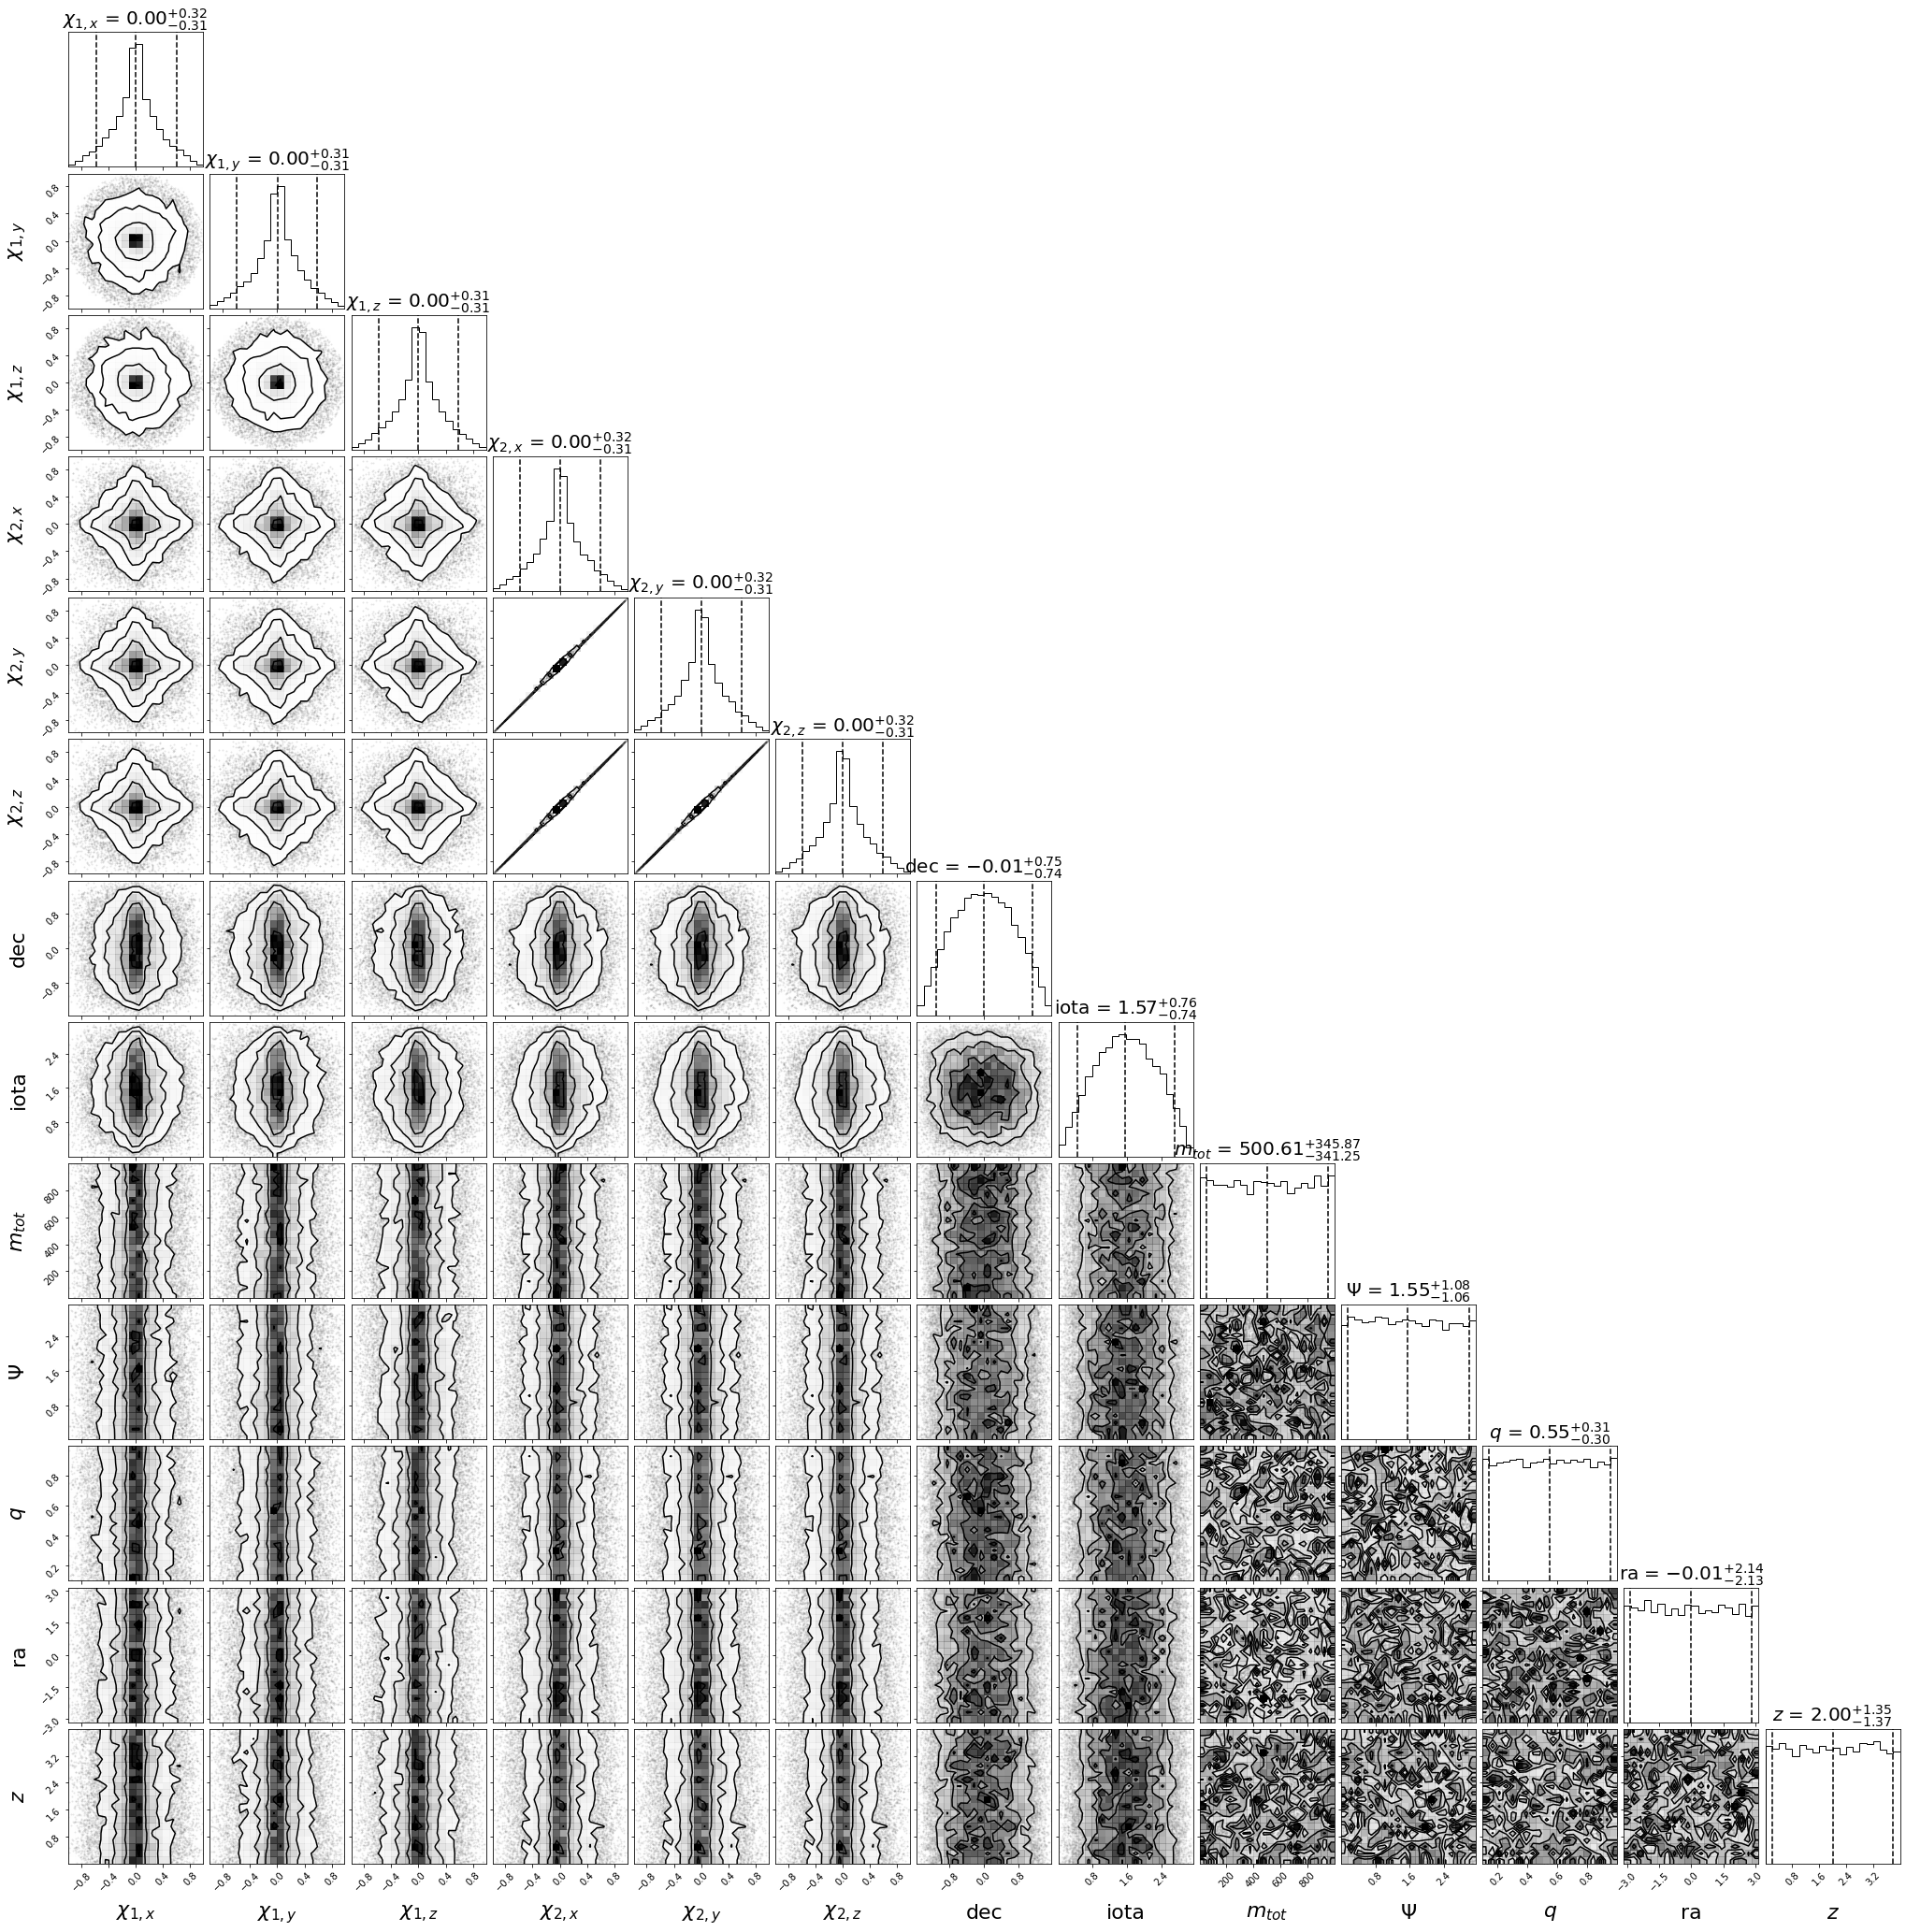

In [7]:
fig = corner.corner(
    N_dim_dataset, labels=[r"$\chi_{1, x}$", r"$\chi_{1, y}$", r"$\chi_{1, z}$", r"$\chi_{2, x}$", 
                           r"$\chi_{2, y}$", r"$\chi_{2, z}$", r"dec", r"iota", r"$m_{tot}$", r"$\Psi$", 
                           r"$q$", r"ra", r"$z$"], quantiles=[0.05, 0.5, 0.95], show_titles=True, title_kwargs={"fontsize": 20}, 
    label_kwargs=dict(fontsize=22), figsize=(16, 20)
);

I zoom into the different marginalised 1D distributions to better see which of them are most valuable to the detectors:

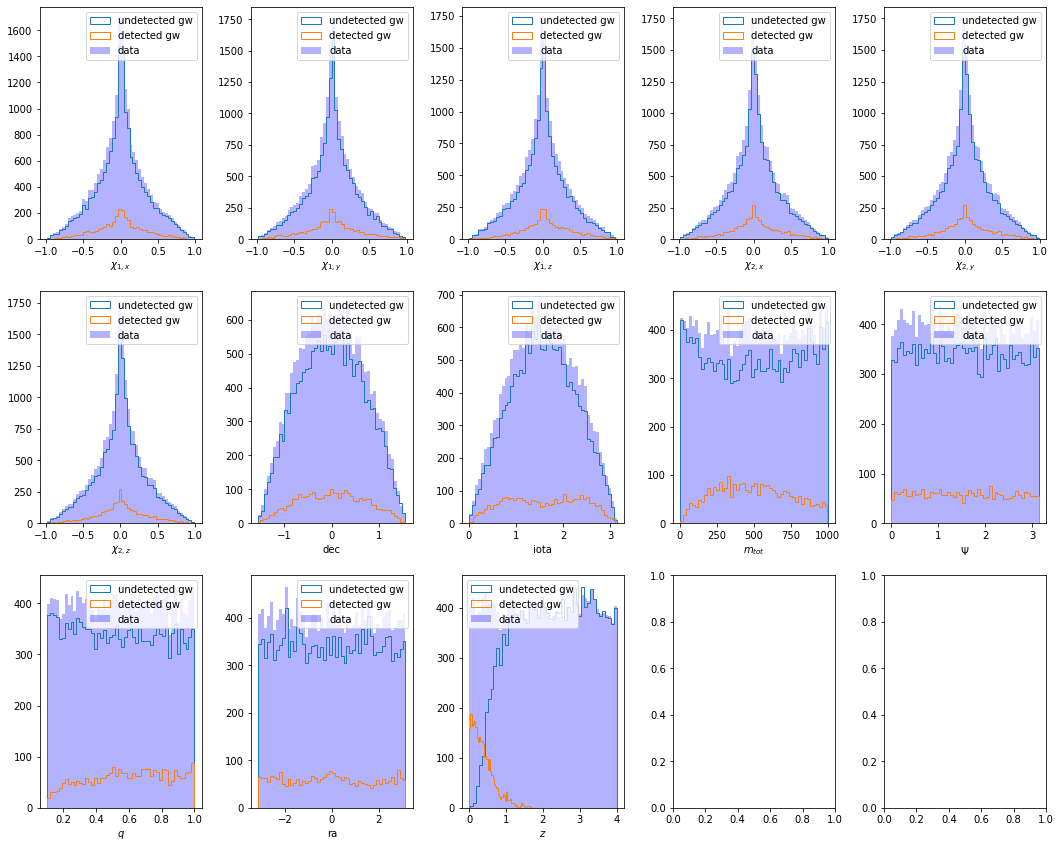

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(15, 12))

labels=[r"$\chi_{1, x}$", r"$\chi_{1, y}$", r"$\chi_{1, z}$", r"$\chi_{2, x}$", 
                           r"$\chi_{2, y}$", r"$\chi_{2, z}$", r"dec", r"iota", r"$m_{tot}$", r"$\Psi$", 
                           r"$q$", r"ra", r"$z$"]

for ax, data, xlabel in zip(axs.flatten(), N_dim_dataset.T, labels):
    
    ax.hist(data[det_short==0], bins=50, histtype = 'step', label = 'undetected gw', lw=1)
    ax.hist(data[det_short==1], bins=50, histtype = 'step', label = 'detected gw', lw=1)
    ax.hist(data, bins=50, label = 'data', color='blue', alpha=0.3)
    ax.legend()
    ax.set_xlabel(xlabel)
    
plt.tight_layout(pad=1.5);

# "Whole bunch" analysis

I decided to go for the Random Forest classifier. I am first interested in knowing what "forest depth" to set. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(N_dim_dataset, det_short, test_size=0.2, random_state=42) 

From lecture 20 I take this piece of code which will help me cross-validate the depth value:

In [10]:
# Compute the cross-validation scores for several tree depths (no K-Fold due to computational issues)

depth = np.arange(1, 30)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
y_fit_best = None

for i, d in tqdm.tqdm(enumerate(depth)):
    
    clf = RandomForestClassifier(max_depth=d, random_state=0)
    clf.fit(X_train, y_train)

    y_fit_train = clf.predict(X_train)
    y_fit = clf.predict(X_test)
    rms_train[i] = np.mean(np.sqrt((y_fit_train - y_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((y_fit - y_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        y_fit_best = y_fit

best_depth = depth[i_best]

29it [02:02,  4.21s/it]


In [11]:
print("best depth:", best_depth)

best depth: 21


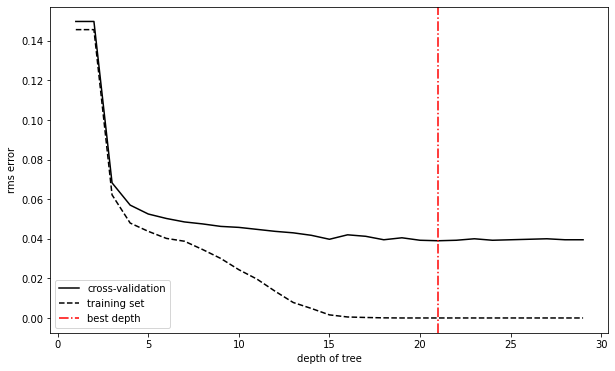

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(depth, rms_test, '-k', label='cross-validation')
plt.plot(depth, rms_train, '--k', label='training set')
plt.axvline(x=best_depth, c='red', linestyle='-.', label='best depth')
plt.xlabel('depth of tree')
plt.ylabel('rms error')

plt.legend(loc='lower left');

I now run the analysis with the best depth:

In [15]:
ranfor = RandomForestClassifier(best_depth)
ranfor.fit(X_train, y_train)

y_pred = ranfor.predict(X_test)

In [16]:
completeness, contamination = completeness_contamination(y_pred, y_test)


print("completeness", completeness)
print("contamination", contamination)

completeness 0.8013355592654424
contamination 0.096045197740113


The raw fraction of correctly identified sources is: 

In [17]:
C_rfc = confusion_matrix(y_test, y_pred)
print("C matrix:", C_rfc)
print('')
print("guessed ratio:", np.sum(C_rfc.diagonal())/len(y_test))

C matrix: [[3350   51]
 [ 119  480]]

guessed ratio: 0.9575


### ROC curve

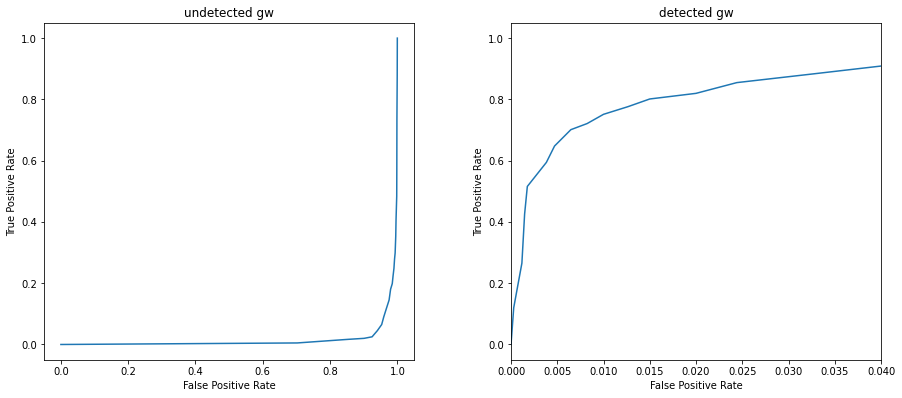

In [18]:
y_score = [ranfor.predict_proba(X_test)[:, 0], ranfor.predict_proba(X_test)[:, 1]]
det_und = ['undetected gw', 'detected gw']

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i in range(0, 2):
    
    fpr_i, tpr_i, _ = roc_curve(y_test, y_score[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(det_und[i])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
axs[1].set_xlim(0, 0.04)  # the one used in the notebook

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

## 13D regression on SNR

I chose to implement the NN for regression: 

In [19]:
def classify(y_pred, y_test): 
    
    observed_pred = np.where(y_pred>12, 1, 0)
    observed_test = np.where(y_test>12, 1, 0)
    
    return observed_pred, observed_test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(N_dim_dataset, snr, test_size=0.2, random_state=42) 

In [21]:
clf = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)  

print([coef.shape for coef in clf.coefs_])  # looking at the weights 

y_pred = clf.predict(X_test)

[(13, 100), (100, 1)]


In [22]:
observed_pred, observed_test = classify(y_pred, y_test)
C_reg_N = confusion_matrix(observed_test, observed_pred)

In [23]:
print("regressor confusion:", C_reg_N)
print("classifier confusion:", C_rfc)

print("regressor guessed:", np.sum(C_reg_N.diagonal())/len(y_test))
print("classifier guessed:", np.sum(C_rfc.diagonal())/len(y_test))

regressor confusion: [[2105 1296]
 [   5  594]]
classifier confusion: [[3350   51]
 [ 119  480]]
regressor guessed: 0.67475
classifier guessed: 0.9575


# 2D analysis

In [24]:
X_2d = np.array([mtot, z]).T
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, det_short, test_size=0.25, random_state=1) 

In [25]:
ranfor = RandomForestClassifier(best_depth)
ranfor.fit(X_train_2d, y_train_2d)

y_pred_2d = ranfor.predict(X_test_2d)

In [26]:
completeness, contamination = completeness_contamination(y_pred_2d, y_test_2d)


print("completeness", completeness)
print("contamination", contamination)

completeness 0.7567567567567568
contamination 0.16477272727272727


The raw fraction of correctly identified sources is:

In [27]:
C_2d = confusion_matrix(y_test_2d, y_pred_2d)

print("C matrix:", C_2d)
print('')
print("guessed ratio:", np.sum(C_2d.diagonal())/len(y_test_2d))

C matrix: [[4107  116]
 [ 189  588]]

guessed ratio: 0.939


### ROC curve

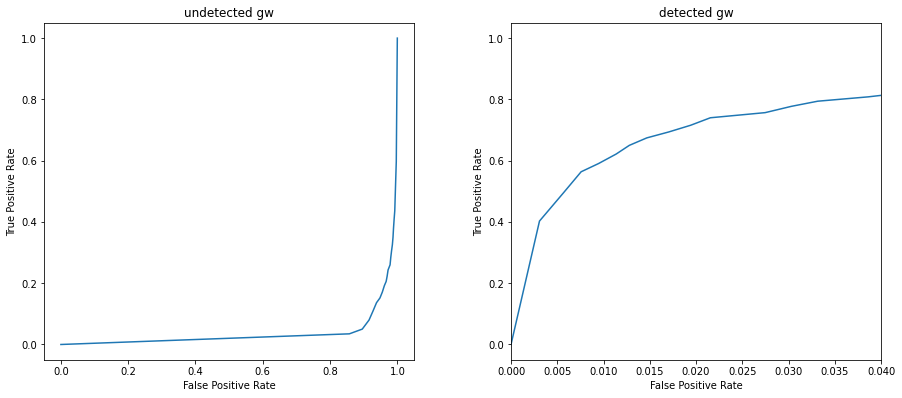

In [28]:
y_score_1 = [ranfor.predict_proba(X_test_2d)[:, 0], ranfor.predict_proba(X_test_2d)[:, 1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i in range(0, 2):
    
    fpr_i, tpr_i, _ = roc_curve(y_test_2d, y_score_1[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(det_und[i])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
axs[1].set_xlim(0, 0.04)  # the one used in the notebook

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

Let me see if another classifier works better. 

In [29]:
gradboost = GradientBoostingClassifier()
gradboost.fit(X_train_2d,y_train_2d)

y_pred_2d = gradboost.predict(X_test_2d)

In [30]:
completeness, contamination = completeness_contamination(y_pred_2d, y_test_2d)


print("completeness", completeness)
print("contamination", contamination)

completeness 0.767052767052767
contamination 0.13872832369942195


The raw fraction of correct sources is: 

In [31]:
C_gradb = confusion_matrix(y_test_2d, y_pred_2d)
print("C matrix:", C_gradb)
print('')
print("guessed ratio:", np.sum(C_gradb.diagonal())/len(y_test_2d))

C matrix: [[4127   96]
 [ 181  596]]

guessed ratio: 0.9446


### ROC curve

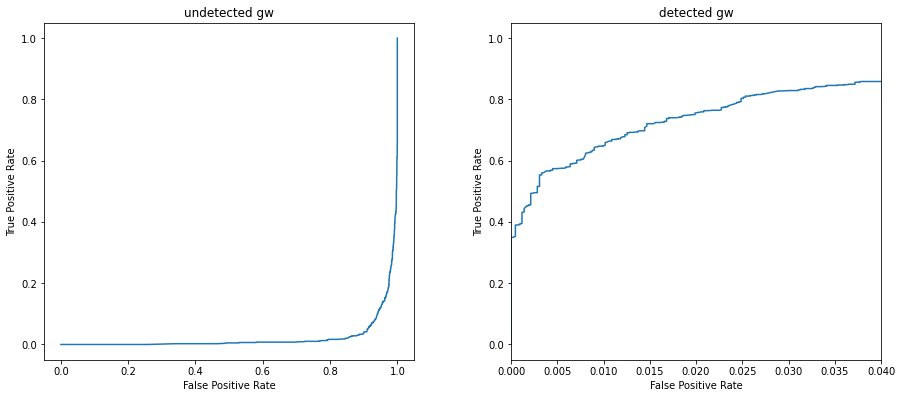

In [32]:
y_score_2 = [gradboost.predict_proba(X_test_2d)[:, 0], gradboost.predict_proba(X_test_2d)[:, 1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i in range(0, 2):
    
    fpr_i, tpr_i, _ = roc_curve(y_test_2d, y_score_2[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(det_und[i])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
axs[1].set_xlim(0, 0.04)  # the one used in the notebook

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

## 2D regression over SNR

In [33]:
snr_short = snr

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, snr_short, test_size=0.25, random_state=1)

In [34]:
clf = MLPRegressor(random_state=1, max_iter=1000).fit(X_train_2d, y_train_2d)  

print([coef.shape for coef in clf.coefs_])  # weights

y_pred_2d = clf.predict(X_test_2d)

[(2, 100), (100, 1)]


In [35]:
observed_pred_2d, observed_test_2d = classify(y_pred_2d, y_test_2d)
C_reg_2 = confusion_matrix(observed_test_2d, observed_pred_2d)

In [36]:
print("regressor confusion:", C_reg_2)
print("rf confusion:", C_2d)
print("gboost confusion:", C_gradb)

print("regressor guessed:", np.sum(C_reg_2.diagonal())/len(y_test_2d))
print("rf guessed:", np.sum(C_2d.diagonal())/len(y_test_2d))
print("gboost guessed:", np.sum(C_gradb.diagonal())/len(y_test_2d))

regressor confusion: [[2830 1393]
 [  10  767]]
rf confusion: [[4107  116]
 [ 189  588]]
gboost confusion: [[4127   96]
 [ 181  596]]
regressor guessed: 0.7194
rf guessed: 0.939
gboost guessed: 0.9446


- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

## PCA

As suggested in the assignment I decided to run a PCA analysis to better see how much variance of my data is encapsuled in the different resulting components. I will first run the PCA, and then try to see the explained variance ratio for each axis. 

In [39]:
num_feats = 13  # n_features

pca = PCA(n_components=num_feats, whiten=True) # having the whitening done doesn't change much in this case
pca.fit(N_dim_dataset)  
evals = pca.explained_variance_ratio_

In [40]:
print(evals)

[9.99915672e-01 3.90845428e-05 1.57989900e-05 9.69104844e-06
 5.57295724e-06 5.50263863e-06 3.95214854e-06 1.32149034e-06
 1.30833034e-06 1.29842518e-06 7.97679181e-07 7.00382342e-38
 3.53405234e-40]


I here see that the first PCA component accounts for 99% of the variance present in my dataset as we see below: 

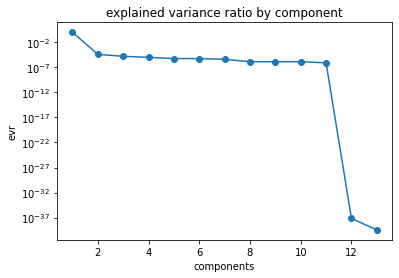

In [41]:
plt.semilogy(range(1, len(evals) + 1), evals, marker='o')
plt.title('explained variance ratio by component')
plt.xlabel('components')
plt.ylabel('evr')
plt.show()

I here report the histogram obtained for the first component: 

In [43]:
N_dim_dataset_reduced = pca.fit_transform(N_dim_dataset)

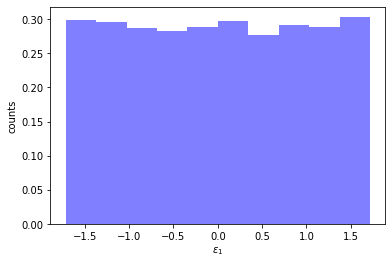

In [44]:
plt.hist(N_dim_dataset_reduced[:, 0], color='blue', alpha=0.5, density=True)
plt.xlabel(r'$\epsilon_1$')
plt.ylabel('counts');